# <CENTER><h1>Reconstruction of invariant mass of Z boson decaying into two leptons </h1></CENTER>

## Simple pyROOT notebook example
<p> In this notebook you can find an easy set of commands that show the basic computing techniques commonly used in high energy  physics (HEP) analyzes. It also shows how to create a histogram, fill it, draw it and use a fit function on it. Moreover it is an introduction to [ROOT](https://root.cern.ch/) too. At the end you get a plot with the invariant mass of the two leptons system, which represents the mass of Z boson.</p>

<p> The Analysis is implemented by using some useful tools, such as pandas (to storage dataframes), numpy (the numerical library of python), uproot3 (to read root files), matplotlib (to plot our graphics) and scipy libary (which allows us to fit our histogram using a gaussian function).

First at all, we should verify that we have installed all need tools to perform our analysis. If we haven't, we can run the next code line:

In [ ]:
import sys
!{sys.executable} -m pip install --upgrade --user pip # update the pip package installer
!{sys.executable} -m pip install -U numpy pandas uproot3 matplotlib --user # install required packages

Now, we can import the tools that we are going to use (pandas, numpy, matplotlib, etc):

In [1]:
import pandas as pd # to store data as dataframes
import numpy as np # for numerical calculations such as histogramming
#import math # for mathematical functions such as square root
import uproot3 # to read .root files as dataframes
import matplotlib.pyplot as plt # for plotting
from scipy.optimize import curve_fit

/cvmfs/sft.cern.ch/lcg/views/LCG_101swan/x86_64-centos7-gcc10-opt/lib/python3.9/site-packages/uproot3/__init__.py:127: FutureWarning: Consider switching from 'uproot3' to 'uproot', since the new interface became the default in 2020.

    pip install -U uproot

In Python:

    >>> import uproot
    >>> with uproot.open(...) as file:
    ...

  warnings.warn(
/cvmfs/sft.cern.ch/lcg/views/LCG_101swan/x86_64-centos7-gcc10-opt/lib/python3.9/site-packages/awkward0/__init__.py:12: FutureWarning: Consider switching from 'awkward0' to 'awkward', since the new interface became the default in 2020.

    pip install -U awkward

In Python:

    >>> import awkward as ak
    >>> new_style_array = ak.from_awkward0(old_style_array)
    >>> old_style_array = ak.to_awkward0(new_style_array)

  warnings.warn(


The root file which contains the events information is storaged in [atlas-opendata-samples-2020-1largeRjet1lep](https://atlas-opendata.web.cern.ch/atlas-opendata/samples/2020/1largeRjet1lep/MC/). So we are going to define the path_file which contains the url and the name of the root file:

In [2]:
path_file = 'https://atlas-opendata.web.cern.ch/atlas-opendata/samples/2020/1largeRjet1lep/MC/mc_361106.Zee.1largeRjet1lep.root'

Using uproot3, we define our tree from the root file and we will print the number of total events by definying a new variable called numevents: 

In [3]:
tree = uproot3.open(path_file)["mini"] # open the tree called mini
numevents = uproot3.numentries(path_file, "mini") # number of events
print("Number of events: ", numevents)

Number of events:  53653


The fraction variable is defined if we don't want to run our analysis over the whole events in the root file, but if it is not the case, you can leave it as iqual to 1.0

In [4]:
fraction = 1.0

Next, we define a function that computes the invariant mass of the two lepton system. This function requires the pT, eta, phi and E of each lepton to return the invariant mass.

In [5]:
def calc_mll(lep_pt,lep_eta,lep_phi,lep_E):
    # first lepton is [0], 2nd lepton is [1] etc
    px_0 = lep_pt[0]*np.cos(lep_phi[0]) # x-component of lepton[0] momentum
    py_0 = lep_pt[0]*np.sin(lep_phi[0]) # y-component of lepton[0] momentum
    pz_0 = lep_pt[0]*np.sinh(lep_eta[0]) # z-component of lepton[0] momentum
    px_1 = lep_pt[1]*np.cos(lep_phi[1]) # x-component of lepton[1] momentum
    py_1 = lep_pt[1]*np.sin(lep_phi[1]) # y-component of lepton[1] momentum
    pz_1 = lep_pt[1]*np.sinh(lep_eta[1]) # z-component of lepton[1] momentum
    sumpx = px_0 + px_1 # x-component of momentum
    sumpy = py_0 + py_1 # y-component of momentum
    sumpz = pz_0 + pz_1 # z-component of momentum 
    sump = np.sqrt(sumpx**2 + sumpy**2 + sumpz**2) # magnitude of momentum 
    sumE = lep_E[0] + lep_E[1] # energy of dilepton system
    return np.sqrt(sumE**2 - sump**2)/1000 #/1000 to go from MeV to GeV

When we want to fit some data to a determined function, we can previously define it and then use it at the end of the analysis. For this reason, we define the gaussian function with the parameters that we are going to fit (amplitude, mu and the standard deviation):  

In [6]:
def gauss(x, amp, mu, sigma):
    return amp*np.exp(-((x-mu)**2)/(2*sigma**2))

Now, we are ready to implement some basic cuts in our data. Here, we can find three main cuts, which are:
<p> 1. At_least_two_leptons: Remove all events in which the lepton number is less than 2.
<p> 2. Opposite_charge_cut: Remove all events in which the two leptons have opposite charge
<p> 3. lep_type_cut: Remove all events in which the two leptons don't belong to the same family.

In [7]:
def at_least_two_leptons_cut(lep_n):
    if(lep_n < 2): return False
    return True


def opposite_charges_cut(lep_charge):
    if(lep_charge[0] == lep_charge[1]): return False
    return True


def lep_type_cut(lep_type):
    if(lep_type[0] != lep_type[1]): return False
    return True

The next code line is going to implement the cuts over the data and save the selected events in a dataframe using pandas. 

In [8]:
data_all = pd.DataFrame() # define empty pandas DataFrame to hold all data for this sample

branches = ["lep_n","lep_charge","lep_type","lep_pt",
            "lep_phi","lep_eta","lep_E"] # add more variables here if you want to use them

for data in tree.iterate(branches, 
                        outputtype=pd.DataFrame, # choose output type as pandas DataFrame
                        entrystop=numevents*fraction): # process up to numevents*fraction
    nIn = len(data.index) # number of events in this batch
    
    # Cut applied in the number of leptons
    data = data[ np.vectorize(at_least_two_leptons_cut)(data.lep_n)]
    
    # Cut applied in the lepton's charge
    data = data[ np.vectorize(opposite_charges_cut)(data.lep_charge)]
    
    # Cut applied in the lepton's type
    data = data[ np.vectorize(lep_type_cut)(data.lep_type)]
    
    # Calculate reconstructed dilepton invariant mass using the function calc_mll defined above
    data['mll'] = np.vectorize(calc_mll)(data.lep_pt,data.lep_eta,data.lep_phi,data.lep_E)
    
    nOut = len(data.index) # number of events passing cuts in this batch
    print("\t nIn: "+str(nIn)+",\t nOut: \t"+str(nOut)) # events before and after
    data_all = data_all.append(data) # append dataframe from this batch to the dataframe for the whole sample

	 nIn: 53653,	 nOut: 	37415


Once we have performed our analysis, we can visualize our selected events and their information (pT, phi, eta, E and the invariant mass of the event) as follow:

In [9]:
data_all ## Use it if you want to see all information about the events
#data_all['lep_pt'] ## Use it if you only want to visualize the pT of the two leptons

,lep_n,lep_charge,lep_type,lep_pt,lep_phi,lep_eta,lep_E,mll
entry,,,,,,,,
0,2,"[1, -1]","[11, 11]","[169903.48, 142998.28]","[3.0199232, -2.9465997]","[-1.8025961, -1.29893]","[529270.06, 281577.66]",93.331758
1,2,"[-1, 1]","[11, 11]","[211820.23, 78281.89]","[-3.0646539, 2.5374086]","[0.047025315, -0.12980008]","[212054.48, 78942.266]",88.992679
2,2,"[1, -1]","[11, 11]","[234039.14, 8108.9414]","[-2.36613, -0.6087628]","[0.5145523, -0.5389483]","[265711.38, 9315.408]",82.511463
3,2,"[-1, 1]","[11, 11]","[282535.56, 60798.965]","[-2.322139, -1.9640917]","[-0.15060467, -0.712555]","[285745.8, 76898.055]",88.020189
4,2,"[-1, 1]","[11, 11]","[193694.88, 135181.3]","[-1.3102051, -1.2278727]","[0.43973032, -0.09355457]","[212725.27, 135773.31]",88.329195
...,...,...,...,...,...,...,...,...
53646,2,"[1, -1]","[11, 11]","[245795.55, 222063.52]","[2.5181298, 2.6780536]","[0.12005247, -0.23323603]","[247568.95, 228130.97]",90.976534
53647,2,"[-1, 1]","[11, 11]","[264119.16, 29385.602]","[-0.56256586, -0.42886025]","[0.5077818, -0.1588098]","[298907.66, 29756.941]",60.965769
53649,2,"[-1, 1]","[11, 11]","[188751.66, 24947.594]","[0.45541525, -0.84419966]","[1.8628806, 1.3455658]","[622643.8, 51151.938]",90.463265


In [10]:
def plot_data():   

    xmin = 40 # GeV
    xmax = 140 # GeV
    step_size = 2 # GeV
    
    bin_edges = np.arange(start=xmin, # The interval includes this value
                     stop=xmax+step_size, # The interval doesn't include this value
                     step=step_size ) # Spacing between values
    bin_centres = np.arange(start=xmin+step_size/2, # The interval includes this value
                            stop=xmax+step_size/2, # The interval doesn't include this value
                            step=step_size ) # Spacing between values

    data_x,_ = np.histogram(data_all['mll'], 
                            bins=bin_edges ) # histogram the data   
         
    data_x_errors = np.sqrt( data_x ) # statistical error on the data

    # Main plot 
    # *************
    plt.axes([0.1,0.3,0.85,0.65]) # left, bottom, width, height 
    main_axes = plt.gca() # get current axes
    
    # plot the data points
    main_axes.errorbar(x=bin_centres, y=data_x, yerr=data_x_errors, 
                      fmt='ko', # 'k' means black and 'o' means circles
                      label='Data' ) 

    # set the x-limit of the main axes
    main_axes.set_xlim( left=xmin, right=xmax ) 
    
    # set the y-axis limit for the main axes
    main_axes.set_ylim( bottom=0, top=np.amax(data_x)*1.1 ) 
    
    # avoid displaying y=0 on the main axes
    main_axes.yaxis.get_major_ticks()[0].set_visible(False) 

    
    # data fit
    
    popt,pcov = curve_fit(gauss, bin_centres, data_x, p0=(10000, 90, 5))
    
    y = gauss(bin_centres, popt[0], popt[1], popt[2])
    
    plt.plot(bin_centres, y, color='r', linestyle='dashed', label='Gaussian Fit Function')
    
    mu = np.format_float_positional(popt[1], unique=False, precision=2)
    sigma = np.format_float_positional(popt[2], unique=False, precision=2)

    # Add text 'Invariant mass of Z boson given by the gaussian fit function'
    plt.text(0.6, # x
             0.56, # y
             'Mass of Z boson given by', # text
             transform=main_axes.transAxes, # coordinate system used is that of main_axes
             style='italic',
             fontsize=10 ) 
    
    plt.text(0.6, # x
             0.5, # y
             'the gaussian fit function', # text
             transform=main_axes.transAxes, # coordinate system used is that of main_axes
             style='italic',
             fontsize=10 ) 
    
    plt.text(0.6, # x
             0.44, # y
             r'$m_{Z} = $ '+mu + '$\pm$' + sigma, # text
             transform=main_axes.transAxes ) # coordinate system used is that of main_axes    
    
    # Add text 'ATLAS Open Data' on plot
    plt.text(0.1, # x
             0.92, # y
             'ATLAS Open Data', # text
             transform=main_axes.transAxes, # coordinate system used is that of main_axes
             fontsize=13 ) 
    
    # Add text 'for education' on plot
    plt.text(0.1, # x
             0.86, # y
             'for education', # text
             transform=main_axes.transAxes, # coordinate system used is that of main_axes
             style='italic',
             fontsize=8 ) 
    
    # Add energy and luminosity
    #lumi_used = str(lumi*fraction) # luminosity to write on the plot
    plt.text(0.1, # x
             0.8, # y
             r'$\sqrt{s}=13 TeV$', # text
             transform=main_axes.transAxes ) # coordinate system used is that of main_axes 
    
    # Add a label for the analysis carried out
    plt.text(0.1, # x
             0.74, # y
             r'$Z \rightarrow l^{+}l^{-}$', # text 
             transform=main_axes.transAxes ) # coordinate system used is that of main_axes

    # draw the legend
    # 'upper left', 'upper right', 'lower left', 'lower right'
    main_axes.legend(frameon=False, # no box around the legend
                     loc='upper right' ) # legend location 
    
    # x-axis label
    plt.xlabel(r'di-lepton invariant mass $\mathrm{m_{ll}}$ [GeV]')
    
    # y-axis label
    plt.ylabel('Events')

    plt.xticks(np.arange(xmin, xmax, step=10))
    
    plt.yticks(np.arange(0, 10000, step=1000))
    
    plt.title('Mass of the Z boson')
    plt.savefig('Zmass_pandas_p.pdf')
    return

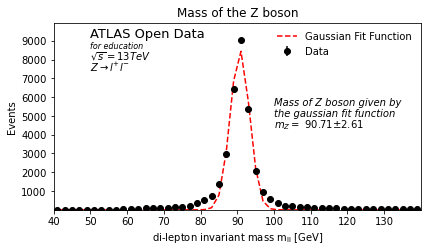

In [11]:
plot_data()

In [12]:
def plot_data_2(data):
    
    xmin = 40 # GeV
    xmax = 140 # GeV
    step_size = 2 # GeV

    bin_edges = np.arange(start=xmin, # The interval includes this value
                     stop=xmax+step_size, # The interval doesn't include this value
                     step=step_size ) # Spacing between values
    bin_centres = np.arange(start=xmin+step_size/2, # The interval includes this value
                            stop=xmax+step_size/2, # The interval doesn't include this value
                            step=step_size ) # Spacing between values

    main_axes = plt.gca() # get current axes
    
    # plot data histogram
    data_hist = main_axes.hist(data['mll'], bins=bin_edges, color='#0011ff', label='Data') #color='#40ff00, label='data'
    
    # set the x-limit of the main axes
    main_axes.set_xlim( left=xmin, right=xmax ) 
    
    # set the axis tick parameters for the main axes
    main_axes.tick_params(which='both', # ticks on both x and y axes
                          direction='in', # Put ticks inside and outside the axes
                          top=False, # draw ticks on the top axis
                          right=False ) # draw ticks on right axis
    
    # x-axis label
    main_axes.set_xlabel(r'2-lepton invariant mass $\mathrm{m_{ll}}$ [GeV]',
                        fontsize=13, x=1, horizontalalignment='right' )
    
    # write y-axis label for main axes
    main_axes.set_ylabel('Events / '+str(step_size)+' GeV',
                         y=1, horizontalalignment='right')
    
    plt.xticks(np.arange(xmin, xmax, step=10))
    
    plt.yticks(np.arange(0, 10000, step=1000))
    
    plt.title('Mass of the Z boson')
    
    # data fit
    
    data_x,_ = np.histogram(data_all['mll'], bins=bin_edges ) # histogram the data   
        
    popt,pcov = curve_fit(gauss, bin_centres, data_x, p0=(10000, 90, 5))
    
    y = gauss(bin_centres, popt[0], popt[1], popt[2])
    
    plt.plot(bin_centres, y, color='r', linestyle='dashed', label='Gaussian Fit Function')
    
    mu = np.format_float_positional(popt[1], unique=False, precision=2)
    sigma = np.format_float_positional(popt[2], unique=False, precision=2)

    # Add text 'Invariant mass of Z boson given by the gaussian fit function'
    plt.text(0.6, # x
             0.56, # y
             'Mass of Z boson given by', # text
             transform=main_axes.transAxes, # coordinate system used is that of main_axes
             style='italic',
             fontsize=10 ) 
    
    plt.text(0.6, # x
             0.5, # y
             'the gaussian fit function', # text
             transform=main_axes.transAxes, # coordinate system used is that of main_axes
             style='italic',
             fontsize=10 ) 
    
    plt.text(0.6, # x
             0.44, # y
             r'$m_{Z} = $ '+mu + '$\pm$' + sigma, # text
             transform=main_axes.transAxes ) # coordinate system used is that of main_axes   
    
    # draw the legend
    main_axes.legend( frameon=False,
                    loc='upper right' ) # no box around the legend 
    
    # Add text 'ATLAS Open Data' on plot
    main_axes.text(0.05, # x
             0.93, # y
             'ATLAS Open Data', # text
             transform=main_axes.transAxes, # coordinate system used is that of main_axes
             fontsize=13 ) 
    
    # Add text 'for education' on plot
    main_axes.text(0.05, # x
             0.88, # y
             'for education', # text
             transform=main_axes.transAxes, # coordinate system used is that of main_axes
             style='italic',
             fontsize=8 )
    
    main_axes.text(0.05, # x
             0.8, # y
             r'$\sqrt{s}=13 TeV$', # text
             transform=main_axes.transAxes ) # coordinate system used is that of main_axes 
    
    # Add a label for the analysis carried out
    main_axes.text(0.05, # x
             0.74, # y
             r'$Z \rightarrow l^{+}l^{-}$', # text 
             transform=main_axes.transAxes ) # coordinate system used is that of main_axes
    plt.savefig('Zmass_pandas_h.pdf')
    return

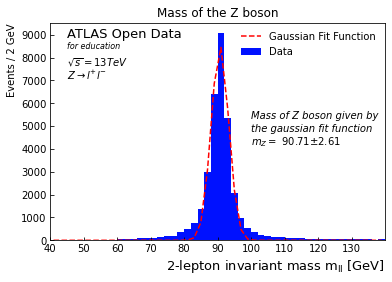

In [13]:
plot_data_2(data_all)